DS3000 Project -
Group 17 -
Aditya Pathak, Jack Mitchell, Jacob Rocque, Sraghvi Anchaliya

Heart Health through Machine Learning: Predictive Modeling for heart Disease Detection 

In [322]:
# general imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# imports for model training, testing, and evaluation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [323]:
# define a global random seed
SEED = 96

In [324]:
# load the dataset
df = pd.read_csv('Cardiovascular_Disease_Dataset.csv')

# convert specified columns to categorical
categorical_columns = ['gender', 'chestpain', 'restingrelectro', 'exerciseangia', 'slope', 'target', 'fastingbloodsugar']
df[categorical_columns] = df[categorical_columns].astype('category')

# types are all good
print(df.dtypes)

patientid               int64
age                     int64
gender               category
chestpain            category
restingBP               int64
serumcholestrol         int64
fastingbloodsugar    category
restingrelectro      category
maxheartrate            int64
exerciseangia        category
oldpeak               float64
slope                category
noofmajorvessels        int64
target               category
dtype: object


In [325]:
# isolate rows with duplicated data
duplicates = df[df.duplicated(keep=False)]

# no duplicated data
print()
print(f'{len(duplicates)} duplicates were found.')

# isolate rows with missing/invalid data to identify patterns
nan_rows = df[df.isna().any(axis=1)]

# no missing/invalid data
print()
print(f'{len(nan_rows)} missing data were found.')

# invalid 0s in cholesteral column
print(df.describe())

# calculate mean excluding zeros
mean_serumcholestrol = df.loc[df['serumcholestrol'] != 0, 'serumcholestrol'].mean()

# impute the mean where 0s are present
df['serumcholestrol'] = df['serumcholestrol'].replace(0, mean_serumcholestrol)

df


0 duplicates were found.

0 missing data were found.
          patientid         age    restingBP  serumcholestrol  maxheartrate  \
count  1.000000e+03  1000.00000  1000.000000      1000.000000   1000.000000   
mean   5.048704e+06    49.24200   151.747000       311.447000    145.477000   
std    2.895905e+06    17.86473    29.965228       132.443801     34.190268   
min    1.033680e+05    20.00000    94.000000         0.000000     71.000000   
25%    2.536440e+06    34.00000   129.000000       235.750000    119.750000   
50%    4.952508e+06    49.00000   147.000000       318.000000    146.000000   
75%    7.681877e+06    64.25000   181.000000       404.250000    175.000000   
max    9.990855e+06    80.00000   200.000000       602.000000    202.000000   

           oldpeak  noofmajorvessels  
count  1000.000000       1000.000000  
mean      2.707700          1.222000  
std       1.720753          0.977585  
min       0.000000          0.000000  
25%       1.300000          0.000000  


,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,328.877508,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229.000000,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142.000000,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295.000000,1,1,153,0,3.2,2,2,1
4,146211,31,1,1,199,328.877508,0,2,136,0,5.3,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9949544,48,1,2,139,349.000000,0,2,183,1,5.6,2,2,1
996,9953423,47,1,3,143,258.000000,1,1,98,1,5.7,1,0,0
997,9965859,69,1,0,156,434.000000,1,0,196,0,1.4,3,1,1
998,9988507,45,1,1,186,417.000000,0,1,117,1,5.9,3,2,1


View distribution of categorical data.

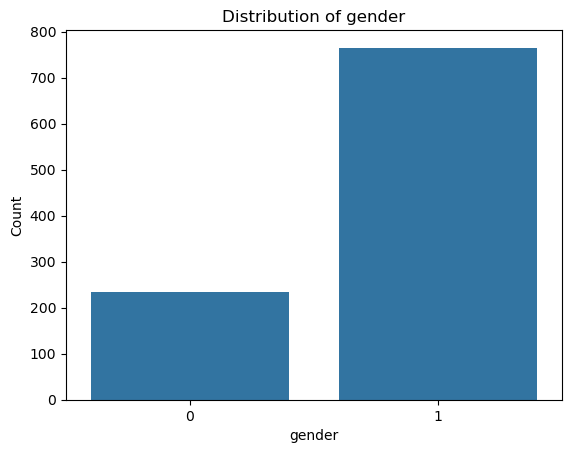

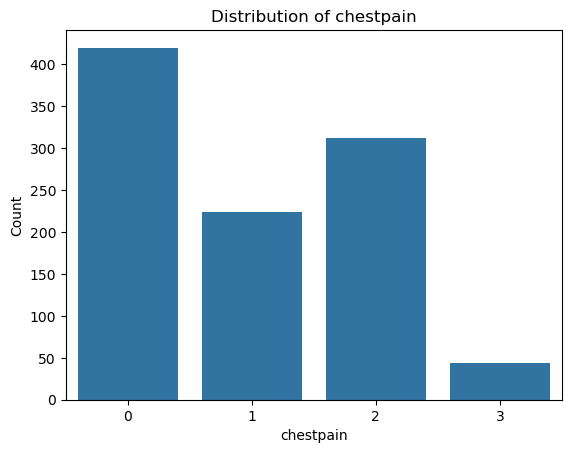

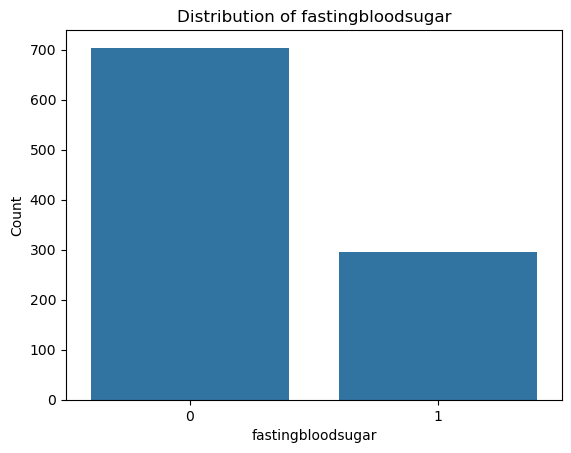

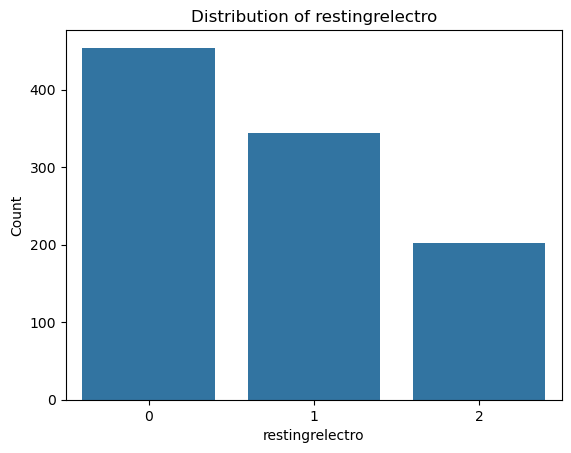

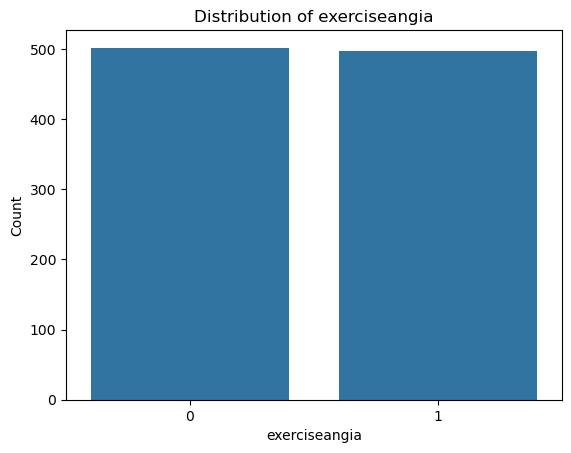

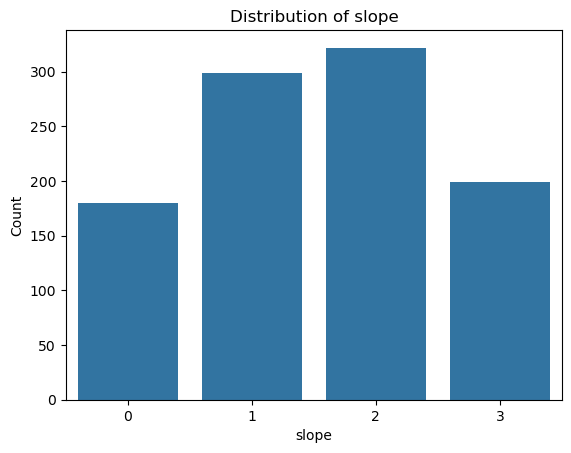

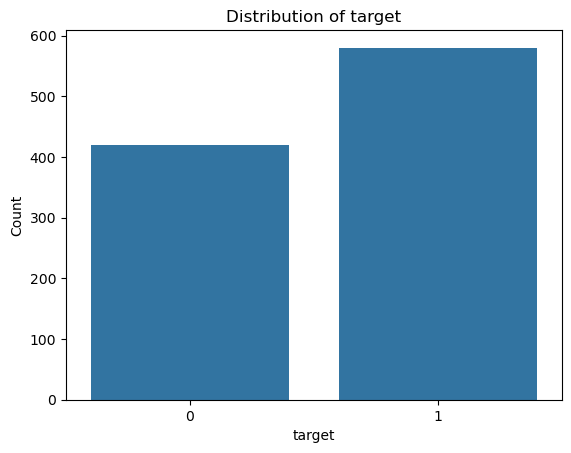

In [326]:
# Distributions of categorical data
for column in df.columns:
    if df[column].dtype == 'category':
        plt.figure()
        sns.countplot(data=df, x=column)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.show()

Look at numerical data distributions and find correlations between numerical data and target.

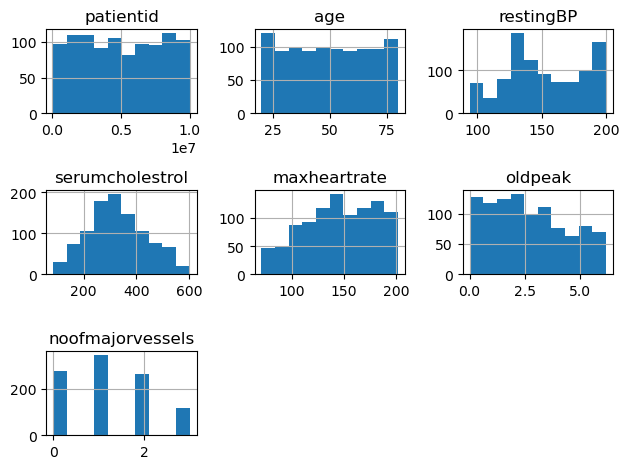

restingBP: correlation = 0.48, p-value = 0.0
serumcholestrol: correlation = 0.37, p-value = 0.0
maxheartrate: correlation = 0.23, p-value = 0.0
oldpeak: correlation = 0.1, p-value = 0.0
noofmajorvessels: correlation = 0.49, p-value = 0.0


In [327]:
# generate histograms for each feature
df.hist()

plt.tight_layout()
plt.show()

# calculate correlations and p-values with target
correlations_with_target = {}
for column in df.columns:
    if df[column].dtype != 'category':
        if column != 'target':
            correlation, p_value = pearsonr(df[column], df['target'])
            correlations_with_target[column] = {'correlation': round(correlation, 2), 'p_value': round(p_value, 2)}

significant_columns = []
# print the correlations and p-values if statistically significant
for column, value in correlations_with_target.items():
    if value['p_value'] <= 0.05:
        print(f"{column}: correlation = {value['correlation']}, p-value = {value['p_value']}")

        significant_columns.append(column)

Generate correlations with the target column for statistically significant numerical features.

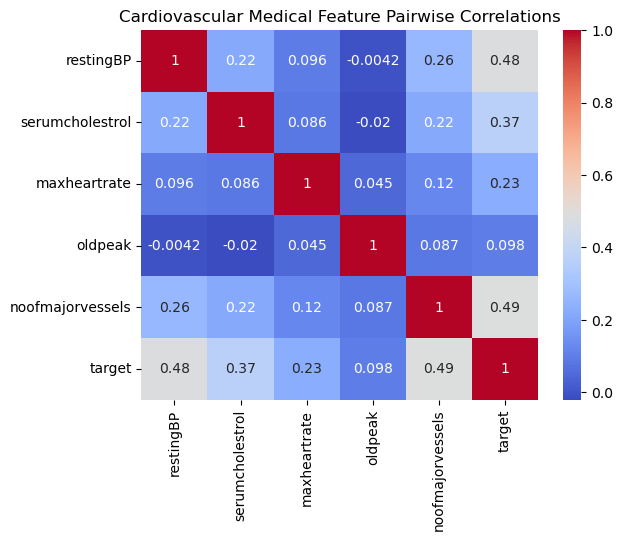

In [328]:
# append target to significant columns
significant_columns.append('target')

# Generate correlation coefficients for numerical columns
correlation_matrix = df[significant_columns].corr()

# generate a correlation matrix to see r squared correlation values
# generate a heatmap to visualize correlations
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# title visualization
plt.title('Cardiovascular Medical Feature Pairwise Correlations')

plt.show()

Most variables are positively correlated with each other, and all of these variables are signficiantly correlated with the target. Doing some medical research, we learned electrocardiograms (EKGs) are very relevant to heart disease detection, so let's compare the slope column, which represents the slope of the ST segment of an EKG during exercise, with the target. According to the graph, there is some strong correlation.

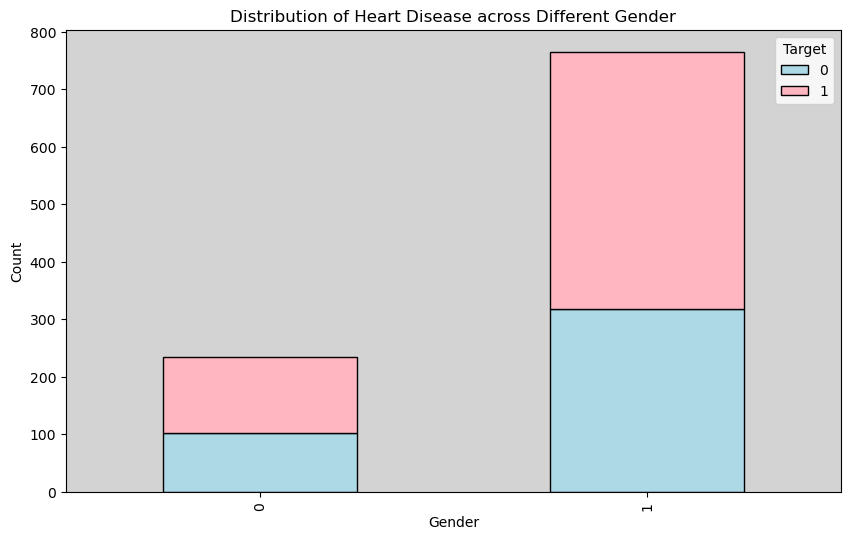

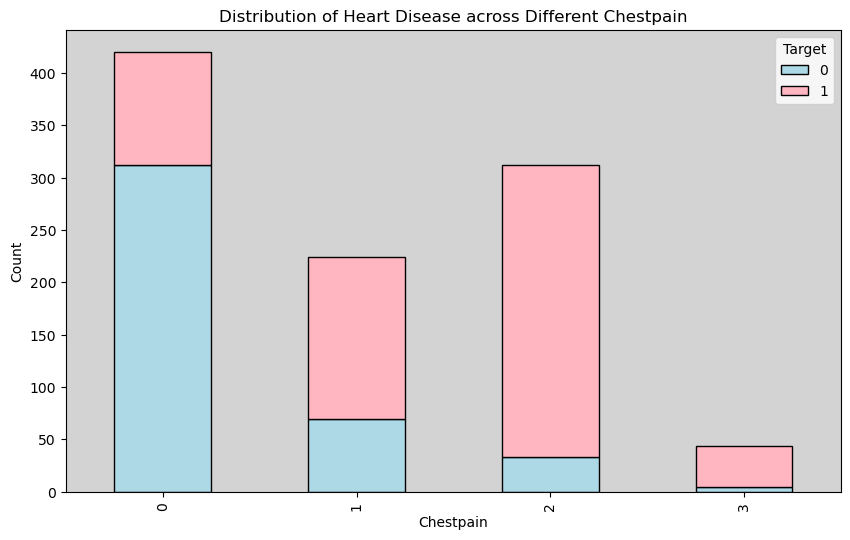

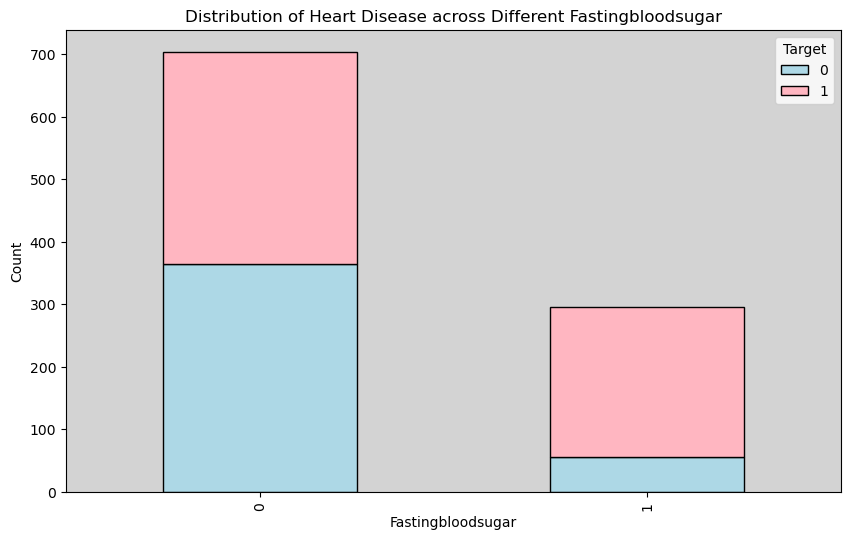

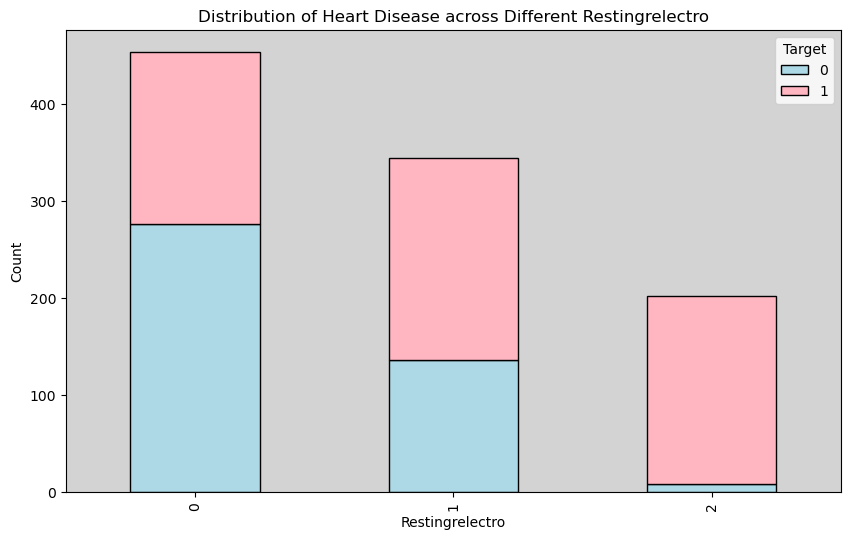

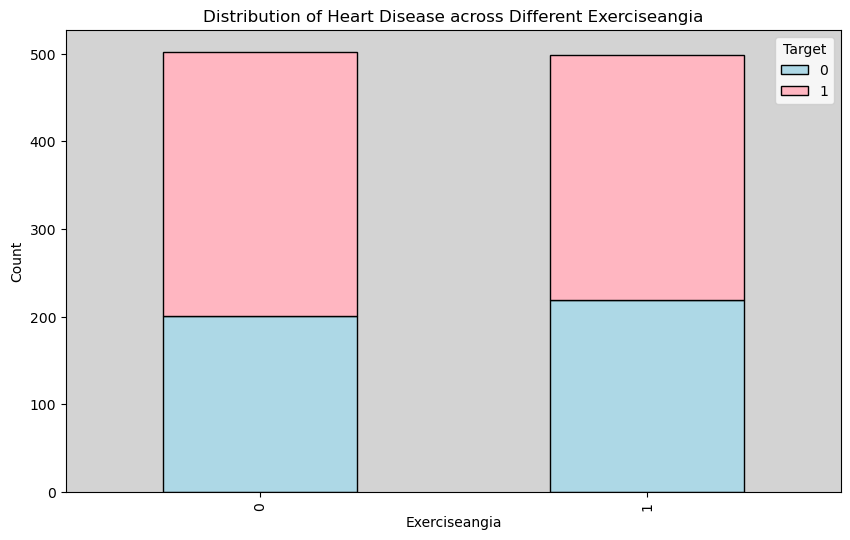

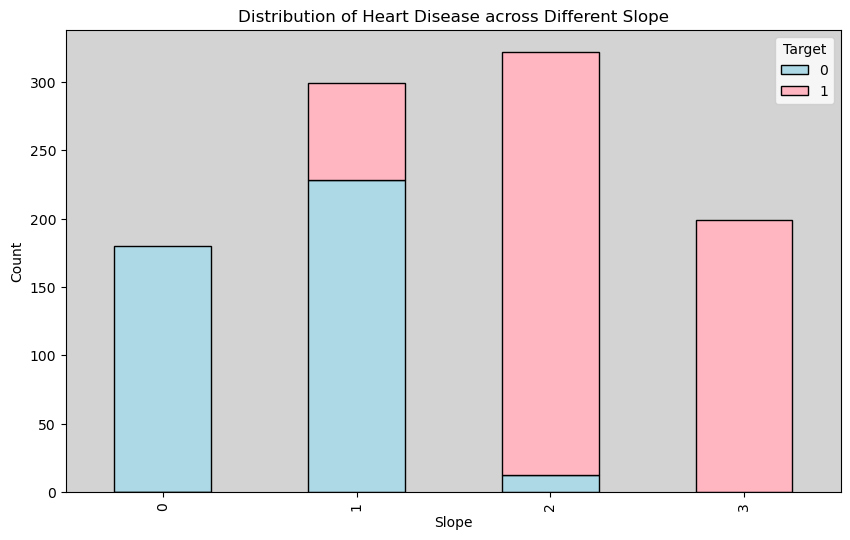

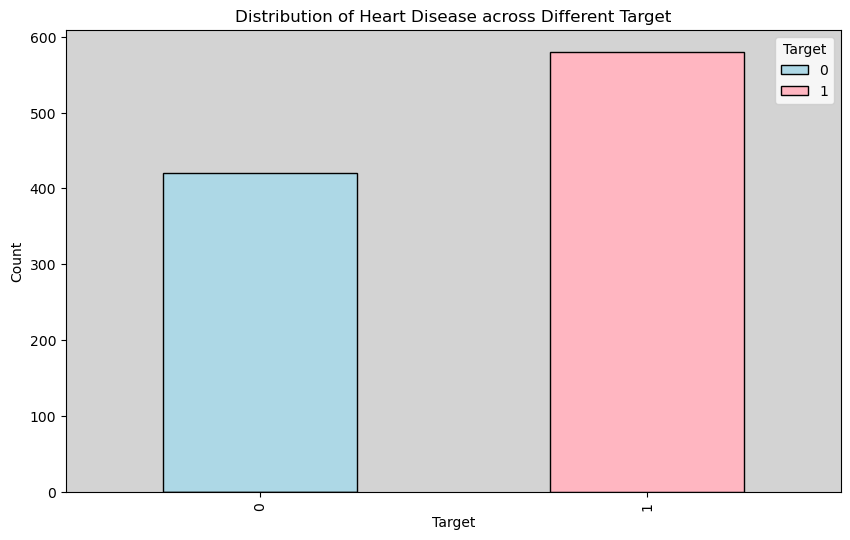

In [329]:
# Isolate 
cat_columns = df.select_dtypes(include='category').columns  # Get all categorical columns

# Loop through each categorical column
for col in cat_columns:
    # Create a cross tab of the current categorical column and target for stacked bar chart
    cross_tab = pd.crosstab(df[col], df['target'])
    
    # Create a stacked bar chart
    cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6), 
                   color=['lightblue', 'lightpink'], edgecolor='black')  # Set colors and outlines
    
    # Title graph and axes
    plt.title(f'Distribution of Heart Disease across Different {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Count')
    
    # Add a legend
    plt.legend(title='Target')
    
    # Change background color
    plt.gca().set_facecolor('lightgray')
    
    plt.show()

Let's do something similar for resting blood pressure.

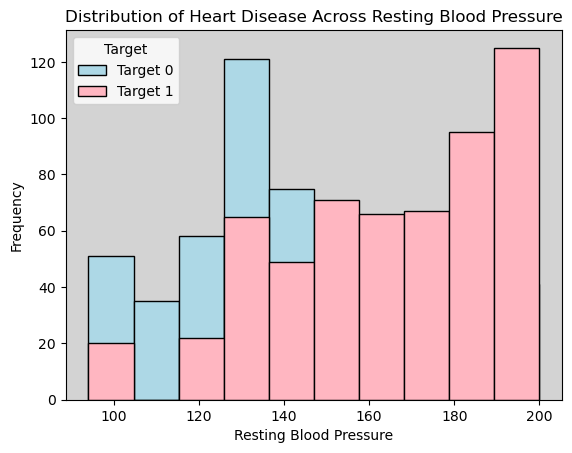

In [330]:
# seperate data into those with and without heart disease
target_0 = df[df['target'] == 0]['restingBP']
target_1 = df[df['target'] == 1]['restingBP']

# plot histograms for each group
plt.hist(target_0, color='lightblue', label='Target 0', edgecolor='black')
plt.hist(target_1, color='lightpink', label='Target 1', edgecolor='black')

# title graph and axes 
plt.title('Distribution of Heart Disease Across Resting Blood Pressure')
plt.xlabel('Resting Blood Pressure')
plt.ylabel('Frequency')

# add a legend
plt.legend(title='Target')

plt.gca().set_facecolor('lightgray')  # change background color

plt.show()

We are attempting to predict the prescence of heart disease based variety of different medical variables. Therefore, we are performing classification. In this project, we will go through the training, evaluation, and tuning of a K Nearest Neighbor Classifier, Random Forest Classifier and Support Vector Machine Model. The results we be compared using accuracy scores to determine the best model for predicitng the prescence of heart disease. We chose these three models because they can make predictions for classifications and support non-linear data. By evaluating and comparing all three models, we can choose the most appropriate one for our data

First, we'll do some feature engineering. We'll also normalize the data.

In [331]:
# select appropriate features - patient id is not relevant to the classifier
df.drop(columns='patientid', inplace=True)

# ensure classes are evenly distributed
print('Class distribution:', df['target'].value_counts())

# separate data into X and y
X = df.drop(columns=['target'])  # observations
y = df['target']                 # labels

# normalize and encode data - KNN is sensitive to distance so normalization is important
categorical_cols = [col for col in X.columns if X[col].dtype == 'category']  # get categorical columns
numerical_cols = [col for col in X.columns if col not in categorical_cols]  # get numerical columns

# normalize each numerical column
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# encode all categorical data
encoder = OneHotEncoder()
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_cols]).toarray(), columns=encoder.get_feature_names_out(categorical_cols))

# replace categorical columns with encoded ones
X.drop(columns=categorical_cols, inplace=True)
X = pd.concat([X, X_encoded], axis=1)

Class distribution: target
1    580
0    420
Name: count, dtype: int64


In [332]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,                  # observations
                                                    y,                  # labels
                                                    test_size = 0.3,    # 30% of data for testing
                                                    random_state=SEED,  # global seed for reproducibility
                                                    stratify=y          # preserve distriubtion labels
                                                    )

First, the KNN Model:

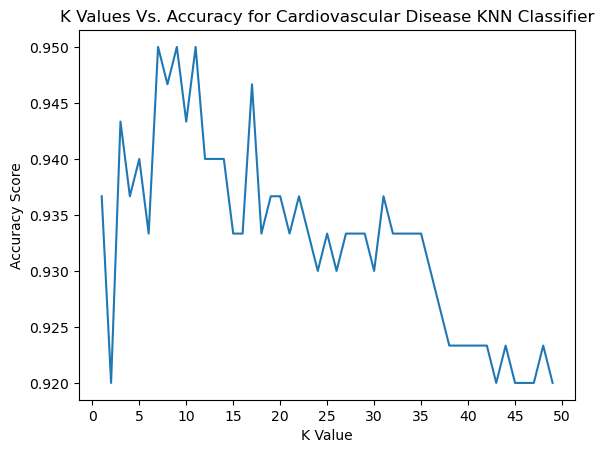

Best k value:, 7


In [333]:
# build knn model, plot different values of k and accuracy score
# generate list of k values to test and empty list for accuracy score
k_list = list(range(1, 50))
knn_scores = []

# iterate through each k value and generate a new accuracy score for each
for k in k_list:

    # initialize and fit K nearest neighbors classifier
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)

    # predict labels for test set
    knn_y_pred = knn.predict(X_test)

    # generate accuarcy score for each model
    knn_accuracy = accuracy_score(y_test, knn_y_pred)
    knn_scores.append(knn_accuracy)

# plot k value vs. accuracy score
plt.plot(k_list, knn_scores)

plt.xticks(np.arange(0, 51, step=5))  # step xlabels by 2

# title and label plot
plt.title('K Values Vs. Accuracy for Cardiovascular Disease KNN Classifier')
plt.xlabel('K Value')
plt.ylabel('Accuracy Score')

plt.show()

# identify and print index of highest k_score
max_index = np.argmax(knn_scores)
k_score = k_list[max_index]

print('Best k value:,', k_score)

Seeing as the optimal k value is 7, we will create, evaluate, and tune a model using that value

In [334]:
# initialize KNN Classifier with k=3 and fit the data
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train, y_train)

# make predictions for X test data
knn_predictions = knn.predict(X_test)

# print accuracy for this model
best_knn_accuracy = accuracy_score(y_test, knn_predictions)
best_knn_recall = recall_score(y_test, knn_predictions)

print('Untuned KNN Accuracy:', round(best_knn_accuracy, 4))

Untuned KNN Accuracy: 0.95


Let's tune the KNN model to attempt to raise the accuracy score

In [335]:
# generate a new KNN model
tuned_knn = KNeighborsClassifier()

# use GridSearchCV to tune hyperparameters
knn_params = {
    'n_neighbors': np.arange(2, 16, 2),                      # number of neighbors        
    'weights': ['uniform', 'distance'],                      # weight function
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # algorithm used 
    'p': [1, 2],                                             # power parameter
    'leaf_size': [1, 10]                                     # minimum samples for leaf node - added to combat overfitting
}

# compare all combinations of parameters to determine best model with 5 folds
knn_grid = GridSearchCV(tuned_knn, 
                        knn_params,               # give defined parameters
                        cv=6,                     # set 6 folds
                        scoring='accuracy',       # get accuracy scores
                        return_train_score=True   # return scores
                       )

# fit the grid with training data
knn_grid.fit(X_train, y_train)

# print best accuracy and its corresponding parameters
print('Best Accuracy Score:', round(knn_grid.best_score_, 4))
print('Best Parameters:', knn_grid.best_params_)

Best Accuracy Score: 0.9557
Best Parameters: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 14, 'p': 1, 'weights': 'distance'}


Let's evaluate the best KNN model to look for bias-variance problems

In [336]:
# select training and testing scores and stds - define this for all models
cv_result_cols = ['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']

In [337]:
# generate scores from grid search
knn_cv_results = pd.DataFrame(knn_grid.cv_results_)
knn_cv_results = knn_cv_results.sort_values('mean_test_score', ascending=False)

print(knn_cv_results[cv_result_cols].head())

     mean_train_score  std_train_score  mean_test_score  std_test_score
165               1.0              0.0          0.95573        0.015891
137               1.0              0.0          0.95573        0.015891
25                1.0              0.0          0.95573        0.015891
221               1.0              0.0          0.95573        0.015891
109               1.0              0.0          0.95573        0.015891


Resuts initially indicated some overfitting. Our hyperparameter tuning allowed us to increase the accuracy score somewhat by decreasing overfitting. We know the improvements came mostly from fixing overfitting because the testing scores improved more relative to the training scores, allowing us to increase overall accuracy to 0.9557.

Second, the Random Forest Model:

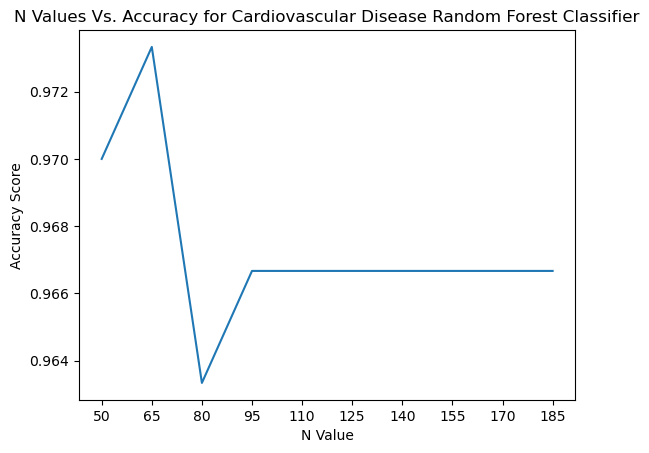

Best n value:, 65


In [338]:
# build rf model, plot different values of n estimators and accuracy score
# generate list of n estimators values to test and empty list for accuracy score
n_list = np.arange(50, 200, 15)
rf_scores = []

# iterate through each n value and generate a new accuracy score for each
for n in n_list:

    # initialize and fit random forest classifier
    knn = RandomForestClassifier(n_estimators = n, random_state=SEED)
    knn.fit(X_train, y_train)

    # predict labels for test set
    rf_y_pred = knn.predict(X_test)

    # generate accuarcy score for each model
    rf_accuracy = accuracy_score(y_test, rf_y_pred)
    rf_scores.append(rf_accuracy)

# plot k value vs. accuracy score
plt.plot(n_list, rf_scores)

plt.xticks(np.arange(50, 200, 15))

# title and label plot
plt.title('N Values Vs. Accuracy for Cardiovascular Disease Random Forest Classifier')
plt.xlabel('N Value')
plt.ylabel('Accuracy Score')

plt.show()

# identify and print index of highest n_score
max_index = np.argmax(rf_scores)
n_score = n_list[max_index]

print('Best n value:,', n_score)

Seeing as the optimal n value is 65, we will create, evaluate, and tune a model using that value

In [339]:
# initialize random forest Classifier with k=3 and fit the data
rf = RandomForestClassifier(n_estimators = 65, random_state=SEED)
rf.fit(X_train, y_train)

# make predictions for X test data
rf_predictions = rf.predict(X_test)

# print accuracy for this model
best_rf_accuracy = accuracy_score(y_test, rf_predictions)

print('Untuned Random Forest Accuracy:', round(best_rf_accuracy, 4))

Untuned Random Forest Accuracy: 0.9733


Let's tune the Random Forest model to attempt to raise the accuracy score

In [340]:
# generate a new random forest model
tuned_rf = RandomForestClassifier(random_state=SEED)

# use GridSearchCV to tune hyperparameters
rf_params = {
    'n_estimators': [180, 200, 220],          # number of trees in the forest
    'max_depth': [8, 9, 10],                  # maximum depth of the tree
    'min_samples_split': [2, 3],              # minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],               # minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]                # whether to bootstrap samples
}

# compare all combinations of parameters to determine best model with 5 folds
rf_grid = GridSearchCV(tuned_rf, 
                        rf_params,                # give defined parameters
                        cv=6,                     # set 6 folds
                        scoring='accuracy',       # get accuracy scores
                        return_train_score=True   # return scores
                      )

# fit the grid with training data
rf_grid.fit(X_train, y_train)

# print best accuracy and its corresponding parameters
print('Best Accuracy Score:', round(rf_grid.best_score_, 4))
print('Best Parameters:', rf_grid.best_params_)

Best Accuracy Score: 0.9757
Best Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 180}


Let's evaluate the best Random Forest model to look for bias-variance problems

In [341]:
# generate scores from grid search
rf_cv_results = pd.DataFrame(rf_grid.cv_results_)
rf_cv_results = rf_cv_results.sort_values('mean_test_score', ascending=False)

print(rf_cv_results[cv_result_cols].head())

    mean_train_score  std_train_score  mean_test_score  std_test_score
65          1.000000         0.000000         0.975698        0.019404
63          1.000000         0.000000         0.975698        0.019404
71          0.999714         0.000639         0.974273        0.018487
55          0.999714         0.000639         0.974273        0.018487
39          0.999428         0.000809         0.974273        0.018487


Results previously indicated very slight overfitting. After changing some hyperparameters, we've increased the test score slightly to 0.9757. By simplifying the model with smaller leaf sizes, we were able to help the overfitting problem. Our best overall accuracy for this model is 0.9757.

Third, the SVM Model:

Let's create an untuned SVM model for comparison

In [342]:
# initialize svm classifier
svm = SVC(random_state=SEED)
svm.fit(X_train, y_train)

# make predictions for X test data
svm_predictions = svm.predict(X_test)

# print accuracy for this model
best_svm_accuracy = accuracy_score(y_test, svm_predictions)

print('Untuned SVM Accuracy:', round(best_svm_accuracy, 4))

Untuned SVM Accuracy: 0.96


Let's tune the SVM model to attempt to raise the accuracy score

In [343]:
# generate a new SVM model
tuned_svm = SVC(random_state=SEED)

# use GridSearchCV to tune hyperparameters
svm_params = {
    'C': [0.01, 0.1, 1, 2],      # regularization parameter
    'kernel': ['linear', 'rbf'], # kernel type
    'gamma': ['scale', 'auto'],  # kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'degree': [1, 2, 3],         # degree for 'poly' kernel
    'coef0': [0.0, 0.1, 1.0],    # independent term in 'poly' and 'sigmoid' kernels
    'shrinking': [False],        # whether to use the shrinking heuristic
    'probability': [False]       # whether to enable probability estimates
}

# compare all combinations of parameters to determine best model with 5 folds
svm_grid = GridSearchCV(tuned_svm, 
                        svm_params,               # give defined parameters
                        cv=6,                     # set 6 folds
                        scoring='accuracy',       # get accuracy scores
                        return_train_score=True   # return scores
                       )

# fit the grid with training data
svm_grid.fit(X_train, y_train)

# print best accuracy and its corresponding parameters
print('Best Accuracy Score:', round(svm_grid.best_score_, 4))
print('Best Parameters:', svm_grid.best_params_)

Best Accuracy Score: 0.9714
Best Parameters: {'C': 2, 'coef0': 0.0, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf', 'probability': False, 'shrinking': False}


Let's evaluate the best SVM model to look for bias-variance problems

In [344]:
# generate scores from grid search
svm_cv_results = pd.DataFrame(svm_grid.cv_results_)
svm_cv_results = svm_cv_results.sort_values('mean_test_score', ascending=False)

print(svm_cv_results[cv_result_cols].head())

     mean_train_score  std_train_score  mean_test_score  std_test_score
125          0.991143         0.002305         0.971412        0.017607
133          0.991143         0.002305         0.971412        0.017607
141          0.991143         0.002305         0.971412        0.017607
109          0.991143         0.002305         0.971412        0.017607
129          0.991143         0.002305         0.971412        0.017607


Initial results indicated some slight overfitting. After lowering 'C' and changing 'shrinking' and 'probability' to false, mean test raised from 0.96 to 0.9714 reducing our overfitting issue while also raising the training score slightly. Things like setting 'shrinking' and 'probability' to false simplified and better generalized the model. Overall accuracy has been increased to 0.9714.

Lastly, compare all three models:

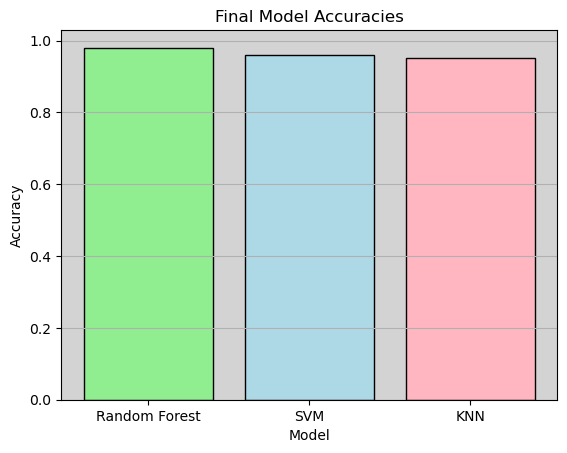

In [345]:
# create lists for final accuracies and their corresponding models
final_accuracies = []
final_models = ["KNN", "Random Forest", "SVM"]

# untuned knn model which performed best:
final_knn = KNeighborsClassifier(**knn_grid.best_params_)

# tuned random forest model which performed best:
# Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
final_rf = RandomForestClassifier(**rf_grid.best_params_, random_state=SEED)

# tuned svm model which performed best:
# Parameters: {'C': 2, 'coef0': 0.0, 'degree': 1, 'gamma': 'scale', 'kernel': 'linear', 'probability': False, 'shrinking': False}
final_svm = SVC(**svm_grid.best_params_)

# get list of final accuracy scores for each model and plot them
for model in [final_knn, final_rf, final_svm]:

    # fit each final model with the training data
    model.fit(X_train, y_train)
    
    # make predictions for X test data
    final_predictions = model.predict(X_test)

    # get final accuracy score for each model
    final_accuracy = accuracy_score(y_test, final_predictions)

    final_accuracies.append(final_accuracy)

# zip data together to sort from largest to smallest accuracy score while maintaining proper order in model list
sorted_data = sorted(zip(final_accuracies, final_models), reverse=True)
final_accuracies, final_models = zip(*sorted_data)

plt.bar(final_models, final_accuracies, color = ['lightgreen', 'lightblue', 'lightpink'], edgecolor='black')  # set colors and outlines

# title plot and axes
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Final Model Accuracies')

plt.gca().set_facecolor('lightgray')  # change background color
plt.grid(axis='y')  # add horizontal gridlines

plt.show()

Seeing as we are dealing with medical predictions, it seems more important to reduce false negatives than false positives. If we ever hope to actually use a model like this, we have to rely on the fact that, for the most part, it's not missing anyone with heart disease. It is more important to catch all heart disease early, even if we accidentally predict the presence of heart disease where it isn't. Even though accuracy is our main metric because it's important to strike a balance between medical resources and catching possible false negatives, we will make sure recall scores are not too low for our model of choice. Based upon the evaluating and hypertuning, we will use the Random Forest predictions.

In [346]:
# get predictions for each model
y_pred_knn = final_knn.predict(X_test)
y_pred_svm = final_svm.predict(X_test)
y_pred_rf = final_rf.predict(X_test)

# get accruacy scores for each model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# get recall scores for each model
recall_knn = recall_score(y_test, y_pred_knn)
recall_svm = recall_score(y_test, y_pred_svm)
recall_rf = recall_score(y_test, y_pred_rf)

# get precision scores for each model
precision_knn = precision_score(y_test, y_pred_knn)
precision_svm = precision_score(y_test, y_pred_svm)
precision_rf = precision_score(y_test, y_pred_rf)

# get f1-score scores for each model
f1_knn = f1_score(y_test, y_pred_knn)
f1_svm = f1_score(y_test, y_pred_svm)
f1_rf = f1_score(y_test, y_pred_rf)

print('KNN Accuracy Score:', round(accuracy_knn, 2))
print('KNN Recall Score:', round(recall_knn, 2))
print('KNN Precision Score:', round(precision_knn, 2))
print('KNN F1 Score:', round(f1_knn, 2))

print()

print('SVM Accuracy Score:', round(accuracy_svm, 2))
print('SVM Recall Score:', round(recall_svm, 2))
print('SVM Precision Score:', round(precision_svm, 2))
print('SVM F1 Score:', round(f1_svm, 2))

print()

print('Random Forest Accuracy Score:', round(accuracy_rf, 2))
print('Random Forest Recall Score:', round(recall_rf, 2))
print('Random Forest Precision Score:', round(precision_rf, 2))
print('Random Forest F1 Score:', round(f1_rf, 2))

KNN Accuracy Score: 0.95
KNN Recall Score: 0.94
KNN Precision Score: 0.97
KNN F1 Score: 0.96

SVM Accuracy Score: 0.96
SVM Recall Score: 0.95
SVM Precision Score: 0.98
SVM F1 Score: 0.97

Random Forest Accuracy Score: 0.98
Random Forest Recall Score: 0.98
Random Forest Precision Score: 0.99
Random Forest F1 Score: 0.98


Therefore, we have confirmed the Random Forest model as being the right choice. It has the best recall and accuracy score as well as precision and f1. The Random Forest model fulfills all of our requirements. It is non-linear, supports multiple features, and can perform classification. It makes very accurate predictions.

Let's examine it further. Let's find the most predictive features. For the encoded categorical variables, there feature importances must be aggregated. We are taking the average of each. For example, slope_0, slope_1, slope_2, and slope_3 will have their value averaged together and represented as one feature.

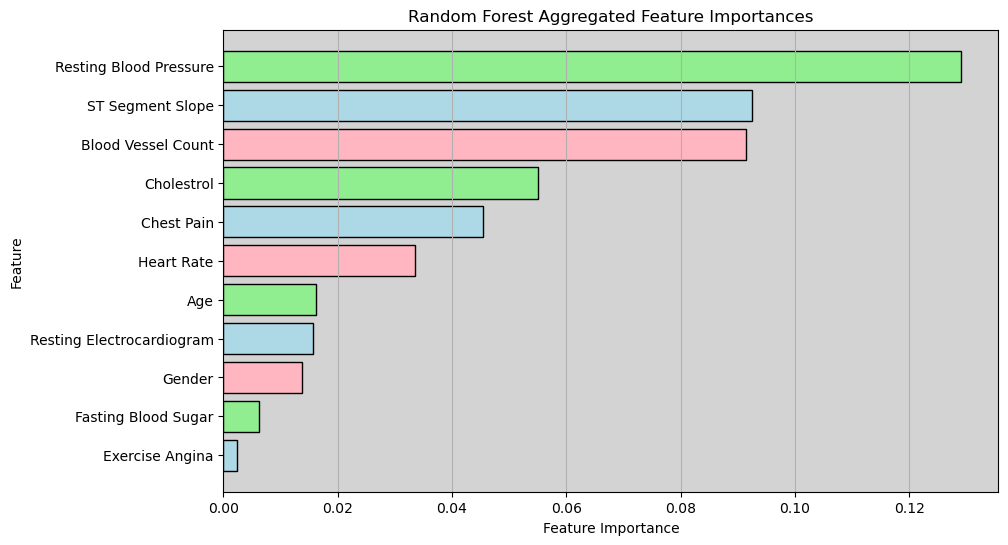

In [347]:
# define list of categorical features and rename them for graph
categorical_features = ['gender', 'chestpain', 'restingrelectro', 'exerciseangia', 'slope', 'fastingbloodsugar']
categorical_features_renamed = ['Gender', 'Chest Pain', 'Resting Electrocardiogram', 'Exercise Angina', 'ST Segment Slope', 'Fasting Blood Sugar']

# define list of categorical features and rename them for graph
numerical_features = ['age', 'restingBP', 'serumcholestrol', 'maxheartrate', 'noofmajorvessels']
numerical_features_renamed = ['Age', 'Resting Blood Pressure', 'Cholestrol', 'Heart Rate', 'Blood Vessel Count']

# combine all features
all_features = categorical_features + numerical_features
all_features_renamed = categorical_features_renamed + numerical_features_renamed  # features renamed for graphing

# get feature importances
feature_importances = final_rf.feature_importances_

agg_importances = {}

# for each categorical variables, aggregate its feature importance
for col, col_renamed in zip(all_features, all_features_renamed):
    
    if col in categorical_features:  # aggregate all categorical variables
        # since encoded feature are the column name + '_' + a number, identify all encoded columns of a feature
        encoded_columns = [col_ for col_ in X.columns if col_[:len(col)+1] == col+'_']
        
        # get those columns' indices
        indices = [X.columns.get_loc(col_) for col_ in encoded_columns]
        
        # get those columns' importances using indices
        importances = feature_importances[indices]
        
        # get average importance for each
        avg_importance = np.mean(importances)
        agg_importances[col_renamed] = avg_importance
        
    else:  # get all numerical importances directly
        index = X.columns.get_loc(col)
        agg_importances[col_renamed] = feature_importances[index]

# sort aggregated importances
sorted_agg_importances = dict(sorted(agg_importances.items(), key=lambda item: item[1], reverse=True))

# plot importances
plt.figure(figsize=(10, 6))
plt.barh(list(sorted_agg_importances.keys()), 
         list(sorted_agg_importances.values()), 
         color = ['lightgreen', 'lightblue', 'lightpink'], edgecolor='black')  # change bar color and add outline

# title plot and axes
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Aggregated Feature Importances')

plt.gca().invert_yaxis()  # put most important features first

plt.gca().set_facecolor('lightgray')  # change background color
plt.grid(axis='x')  # add horizontal gridlines

plt.show()

The most important features make sense, and we are confident that it is the most appropriate model.